In [373]:
# --- Ottimizzazione ---
# La libreria fondamentale per interagire con il solutore Gurobi
import gurobipy as gp
from gurobipy import GRB

# --- Gestione Dati e Calcolo Numerico ---
# Per leggere e manipolare dati in tabelle (DataFrame)
import pandas as pd
# Per calcoli numerici efficienti, specialmente con array
import numpy as np

# --- Visualizzazione dei Risultati ---
# La libreria base per creare grafici e plot
import matplotlib.pyplot as plt
# Un'estensione di matplotlib per grafici statistici più belli
import seaborn as sns

import time

# --- Utilità per Grafi e Barre di Avanzamento ---
# Per creare e manipolare la rete di aeroporti
import networkx as nx
# Per mostrare barre di avanzamento durante i calcoli lunghi (molto comodo!)
from tqdm.notebook import tqdm

# --- Impostazioni Aggiuntive (Opzionale) ---
# Per rendere i grafici di seaborn più belli
sns.set_theme(style="whitegrid")
# Per evitare che pandas mostri i numeri in notazione scientifica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

print("Librerie importate con successo!")

Librerie importate con successo!


In [374]:
print("### PREPARAZIONE DATI PER MODELLO EACN-REG ###")

# --- Parametri di Generazione ---
numero_aeroporti = 6
numero_pop_cells = 10
max_path_len = 2 # Lunghezza massima di un percorso (numero di tratte)
# 3 è quello che mettono nel paper in sezione 4
tau = 800 # Autonomia in km

# --- Generazione Nodi ---
np.random.seed(113)
airport_coords = np.random.randint(0, 1000, size=(numero_aeroporti, 2))
pop_coords = np.random.randint(0, 1000, size=(numero_pop_cells, 2))

# Creiamo un unico DataFrame per tutti i nodi
airports_df = pd.DataFrame({'id': range(numero_aeroporti), 'type': 'airport', 'x': airport_coords[:, 0], 'y': airport_coords[:, 1], 'population': 0})
population_df = pd.DataFrame({'id': range(numero_aeroporti, numero_aeroporti + numero_pop_cells), 'type': 'population', 'x': pop_coords[:, 0], 'y': pop_coords[:, 1], 'population': np.random.randint(1000, 50000, size=numero_pop_cells)})

data_df = pd.concat([airports_df, population_df], ignore_index=True)
print(f"Creato dataset con {numero_aeroporti} aeroporti e {numero_pop_cells} celle di popolazione.")

# --- Creazione del Grafo e dei Percorsi ---
airports = airports_df['id'].tolist()
coords = {row['id']: (row['x'], row['y']) for index, row in airports_df.iterrows()}
dist = { (i, j): np.linalg.norm(np.array(coords[i]) - np.array(coords[j])) for i in airports for j in airports }

# G è un Grafo, contiene gli insiemi dei nodi N (aeroporti) e degli archi E (edges, tratte di volo)
G = nx.Graph()
for i in airports:
    for j in airports:
        if i < j and dist[i,j] <= tau:
            G.add_edge(i, j, weight=dist[i,j]) # Aggiunge edge ij e anche nodi i e j se non già presenti

# Scegliamo una destinazione (es. l'aeroporto 0)
destination_d = 0 
all_paths = []
for source_node in G.nodes():
    if source_node != destination_d:
        # Trova tutti i percorsi semplici tra la sorgente e la destinazione
        paths = nx.all_simple_paths(G, source=source_node, target=destination_d, cutoff=max_path_len - 1)
        all_paths.extend(list(paths))

print(f"Generati {len(all_paths)} possibili percorsi di volo verso la destinazione {destination_d}.")

# --- Associazione Popolazione-Aeroporti ---
# Per ogni cella di popolazione, troviamo l'aeroporto più vicino
pop_to_airport_paths = {}
for idx, pop_row in population_df.iterrows():
    pop_id = pop_row['id']
    pop_coord = (pop_row['x'], pop_row['y'])
    
    # Calcola la distanza da ogni aeroporto
    distances_to_airports = {}
    for airport_id, airport_coord in coords.items():
        distances_to_airports[airport_id] = np.linalg.norm(np.array(pop_coord) - np.array(airport_coord))
    
    # Trova l'aeroporto più vicino
    nearest_airport = min(distances_to_airports, key=distances_to_airports.get)
    
    # Associa i percorsi che partono dall'aeroporto più vicino
    pop_to_airport_paths[pop_id] = [p for p in all_paths if p[0] == nearest_airport]

print("Associazione tra celle di popolazione e percorsi completata.")

### PREPARAZIONE DATI PER MODELLO EACN-REG ###
Creato dataset con 6 aeroporti e 10 celle di popolazione.
Generati 5 possibili percorsi di volo verso la destinazione 0.
Associazione tra celle di popolazione e percorsi completata.


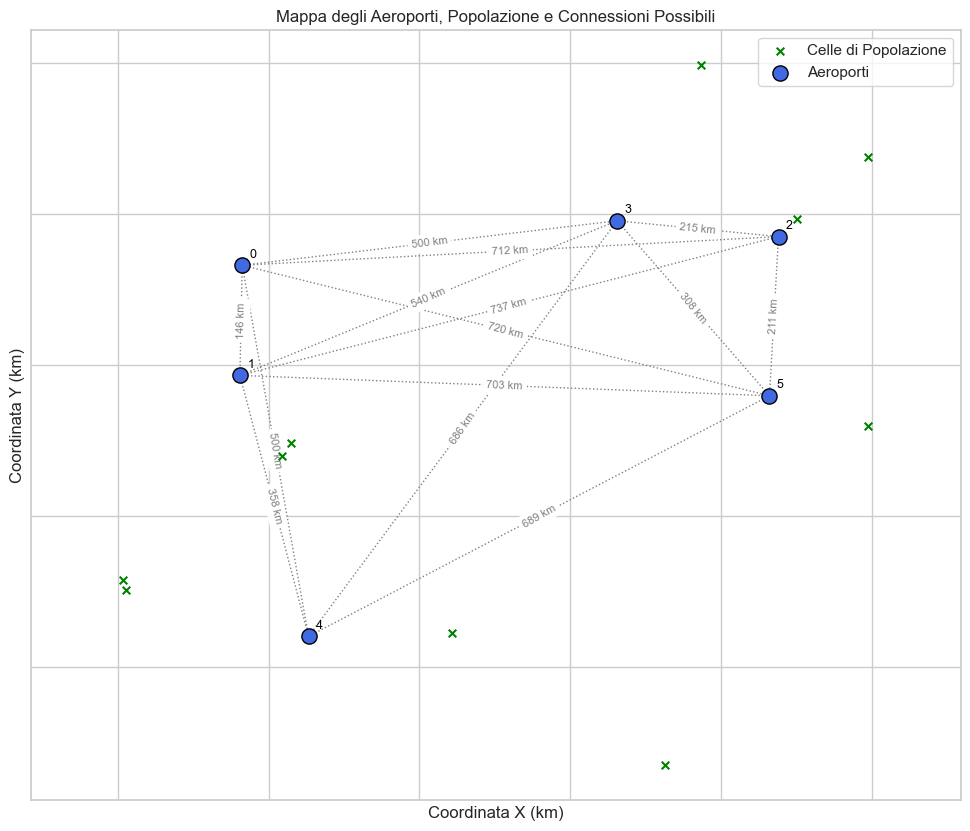

In [375]:
try:
    # --- 1. Separiamo i dati e prepariamo le posizioni ---
    airports_plot_df = data_df[data_df['type'] == 'airport']
    population_plot_df = data_df[data_df['type'] == 'population']
    
    pos = {row['id']: (row['x'], row['y']) for idx, row in airports_plot_df.iterrows()}

    # <<< NUOVO: Creiamo un dizionario per le etichette delle distanze >>>
    # Questo dizionario associa a ogni tratta (es. (0, 2)) la sua distanza in km.
    edge_labels = {
        (u, v): f"{dist[u, v]:.0f} km" for u, v in G.edges()
    }

    # --- 2. Creazione del Grafico ---
    plt.figure(figsize=(12, 10))
    
    # --- Disegniamo il grafo delle connessioni possibili (GLI ARCHI) ---
    nx.draw_networkx_edges(
        G,
        pos, 
        edge_color='gray', 
        style='dotted'
    )
    
    # <<< NUOVO: Aggiungiamo le etichette delle distanze sul grafico >>>
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_color='gray',
        font_size=8
    )
    
    # --- Disegniamo i punti (I NODI) ---
    plt.scatter(population_plot_df['x'], population_plot_df['y'],
                s=30, c='green', marker='x', label='Celle di Popolazione')
    
    plt.scatter(airports_plot_df['x'], airports_plot_df['y'],
                s=120, c='royalblue', marker='o',
                edgecolor='black', label='Aeroporti',
                zorder=5) # zorder alto per disegnarli sopra le linee
    
    # --- 3. Aggiunta delle Etichette ---
    for i, row in airports_plot_df.iterrows():
        plt.text(row['x'] + 10, row['y'] + 10, str(row['id']), fontsize=9, color='black')
        
    # --- 4. Abbellimento del Grafico ---
    plt.title('Mappa degli Aeroporti, Popolazione e Connessioni Possibili')
    plt.xlabel('Coordinata X (km)')
    plt.ylabel('Coordinata Y (km)')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.axis('equal')
    
    plt.show()

except NameError:
    print("Errore: una variabile necessaria ('data_df' o 'G' o 'dist') non è definita.")
    print("Assicurati di eseguire prima la cella che crea o carica i dati.")
except Exception as e:
    print(f"Si è verificato un errore durante la creazione del grafico: {e}")

In [376]:
""""
# ===========================
# Modello EACN-REG Completo 
# ===========================
import time

try:
    # --- 1. Parametri e Dati ---
    mu1 = 100
    mu2 = 10000


    airports = airports_df['id'].tolist() # Estrea indice degli aeroporti 0, 1, ..
    coords = airports_df[['x', 'y']].to_numpy() # Estrae coordinate x e y degli aeroporti
    dist = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2) # Tabella distanze tra aeroporti, distanza ii è zero -> diagonale nulla

    # --- 2. Creazione del Modello Gurobi ---
    m = gp.Model("EACN_REG_Complete_v3")

    # --- 3. Variabili di Decisione ---
    y = m.addVars(airports, vtype=GRB.BINARY, name="y")
    rho = m.addVars(airports, vtype=GRB.CONTINUOUS, name="rho", lb=0.0) # lb -> lower bound, lb=0.0 per porre il vicolo rho[i] >= 0, come da vincolo (7)
    # w = m.addVars(airports, airports, vtype=GRB.BINARY, name="w")
    w = m.addVars([(i, j) for i in airports for j in G.neighbors(i)], vtype=GRB.BINARY, name="w") # -> Correzione chagpt
    chi = m.addVars(airports, vtype=GRB.BINARY, name="chi")

    #  Creiamo un elenco di tratte "canoniche" (ordinate)
    canonical_edges = [tuple(sorted(edge)) for edge in G.edges()] # sorted(edge) se edge = (5,2) -> sorted(edge) = (2,5)
    # Rimuoviamo duplicati se ce ne fossero, tramite set (insieme non ha duplicati) e torniamo a ordinarla
    canonical_edges = sorted(list(set(canonical_edges))) # Lista connessioni tra aeroporti, (i,j) == (j,i)
    # Tutte le connessioni tra gli areoporti, ordinate dall'indice con indice più piccolo come primo elemento della tupla
    
    # Serve per la variabile z_ij = z_ji
    # La variabile z_ij è una variabile binaria che rappresenta la fattibilità strategica di una tratta di volo da i a j.
    # Questo "interruttore" si può accendere (z_ij = 1) se e solo se un aereo può completare l'intero ciclo di missione che passa per quella tratta, ovvero:
    # - Partire da una base di ricarica e arrivare all'aeroporto i (costo in autonomia: rho_i).
    # - Effettuare il volo da i a j (costo in autonomia: d_ij).
    # - Avere abbastanza autonomia residua per poter raggiungere da j la successiva base di ricarica (costo in autonomia: rho_j).
    # Dire che tratta (i,j) è fattibile è come dire che (j,i) è fattibile! Con una ragionevole assunzione che d_ij = d_ji

    z = m.addVars(canonical_edges, vtype=GRB.BINARY, name="z")
    psi = m.addVars(len(all_paths), vtype=GRB.BINARY, name="psi")
    phi = m.addVars(population_df['id'], vtype=GRB.BINARY, name="phi")
    # psi = m.addVars(len(all_paths), vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="psi") # Stavolta ub -> upper bound
    # phi = m.addVars(population_df['id'], vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="phi")

    # --- 4. Funzione Obiettivo ---
    population_covered = gp.quicksum(phi[k] * population_df.set_index('id').loc[k, 'population'] for k in population_df['id']) # Come nel paper, abbiamo una sola destinazione che è indice 0
    installation_cost = gp.quicksum(y[i] for i in airports) # Come nel paper, c_i non c'è è difficile senza avere dati
    m.setObjective(mu1 * population_covered - mu2 * installation_cost, GRB.MAXIMIZE)

    # --- 5. Vincoli --- 
    # M1, M2 , M3 = calculate_tight_big_m(airports_df, dist, G, tau)
    M1, M2, M3 = 2*tau, 2*tau, 2*tau

    # Vincolo (3)
    # (Proposizione 1) permette di tarsformare equazione (11) (eq. non lineare) in una eq. lineare
    for i in airports:
        neighbors = list(G.neighbors(i)) # G.neighbors(i) è una funzione di networkx che ritorna tutti gli aeroporti direttamente collegati a i
        m.addConstr(rho[i] <= M1 * (1 - y[i])) # Vincolo (12)
        m.addConstr(y[i] + gp.quicksum(w[i,j] for j in neighbors) + chi[i] == 1) # Vincolo (16)
        m.addConstr(rho[i] >= M1 * chi[i]) # Vincolo (15)
        for j in neighbors:
            # m.addConstr(rho[i] <= dist[i, j] + rho[j]) # Vincolo (13)
            m.addGenConstrIndicator(w[i,j], 1, rho[i] <= dist[i, j] + rho[j]) # -> modifica proposta da chatgpt
            m.addConstr(rho[i] >= dist[i, j] + rho[j] - M2 * (1 - w[i,j])) # Vincolo (14)
            
    # Vincolo (4): Fattibilità delle tratte z_ij
    for i, j in canonical_edges:
        m.addConstr(dist[i, j] + rho[i] + rho[j] <= tau + M3 * (1 - z[i,j]))

    # Vincolo (5): Fattibilità dei percorsi psi_p
    for p_idx, path in enumerate(all_paths):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            edge = tuple(sorted((u,v)))
            m.addConstr(psi[p_idx] <= z[edge])

    # Vincolo (6): Copertura della popolazione phi_k
    for pop_id in population_df['id']:
        paths_for_pop = pop_to_airport_paths.get(pop_id, [])
        path_indices = [i for i, p in enumerate(all_paths) if p in paths_for_pop]
        if path_indices:
            m.addConstr(phi[pop_id] <= gp.quicksum(psi[p_idx] for p_idx in path_indices))
        else:
            m.addConstr(phi[pop_id] == 0)

    # --- 6. Risoluzione ---
    # Imposta un limite di tempo (300 secondi = 5 minuti)
    m.setParam('TimeLimit', 600)

    print("\nAvvio ottimizzazione modello completo (versione corretta v3)...")
    m.optimize()
    
    # Accetta anche soluzione trovata al TimeLimit
    if m.Status in (GRB.OPTIMAL, GRB.TIME_LIMIT) and m.SolCount > 0:
        print("\n--- Soluzione incumbent trovata ---")
        active_bases = [j for j in airports if y[j].X > 0.5]
        total_pop = population_df['population'].sum()
        covered_pop = sum(phi[k].X * population_df.set_index('id').loc[k, 'population'] for k in population_df['id'])
        print(f"Stato Gurobi: {m.Status}, ObjVal: {m.ObjVal:.2f}, Gap: {m.MIPGap:.6f}")
        print(f"Basi di ricarica installate ({len(active_bases)}): {active_bases}")
        print(f"Popolazione coperta: {covered_pop:,.0f} ({100 * covered_pop / total_pop:.2f}%)")
    else:
        print("Nessuna soluzione trovata. Stato Gurobi:", m.Status)
except Exception as e:
    print(f"Si è verificato un errore: {e}")

"""

'"\n# ===========================\n# Modello EACN-REG Completo \n# ===========================\nimport time\n\ntry:\n    # --- 1. Parametri e Dati ---\n    mu1 = 100\n    mu2 = 10000\n\n\n    airports = airports_df[\'id\'].tolist() # Estrea indice degli aeroporti 0, 1, ..\n    coords = airports_df[[\'x\', \'y\']].to_numpy() # Estrae coordinate x e y degli aeroporti\n    dist = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2) # Tabella distanze tra aeroporti, distanza ii è zero -> diagonale nulla\n\n    # --- 2. Creazione del Modello Gurobi ---\n    m = gp.Model("EACN_REG_Complete_v3")\n\n    # --- 3. Variabili di Decisione ---\n    y = m.addVars(airports, vtype=GRB.BINARY, name="y")\n    rho = m.addVars(airports, vtype=GRB.CONTINUOUS, name="rho", lb=0.0) # lb -> lower bound, lb=0.0 per porre il vicolo rho[i] >= 0, come da vincolo (7)\n    # w = m.addVars(airports, airports, vtype=GRB.BINARY, name="w")\n    w = m.addVars([(i, j) for i in airports for j in G.ne

In [377]:
# ===================================================================
# FASE 2.5: FUNZIONE DI SUPPORTO PER IL RAFFORZAMENTO (Sezione 3.1.1)
# ===================================================================

def calculate_tight_big_m(airports_df, dist, G, tau):
    """
    Calcola i valori "stretti" per i parametri Big-M come descritto
    nella Sezione 3.1.1 del paper.
    """
    print("\nCalcolo dei parametri Big-M stretti...")
    
    airports = airports_df['id'].tolist()
    
    # Calcolo di M1 (un valore per ogni aeroporto, come da Formula 17)
    M1_vals = {}
    for i in airports:
        neighbors = list(G.neighbors(i))
        if not neighbors: # Areoporto è isolato, non ha nessun vicino a distanza < tau
            M1_vals[i] = 0 # Impostare M1_vals[i] = 0 è un modo efficiente per "comunicare" questa informazione al modello. Quando Gurobi vedrà questo valore, il vincolo rho[i] <= 0 * (1 - y[i]) forzerà rho_i a essere 0
        else:
            min_dist_to_neighbor = min(dist[i, j] for j in neighbors)
            # Questa è l'implementazione della logica della Proposizione 2
            M1_vals[i] = tau - min_dist_to_neighbor + 0.001 # + un piccolo epsilon

    # Calcolo di M2 e M3 (un valore per ogni tratta)
    M2_vals = {}
    M3_vals = {}
    for i, j in G.edges():
        edge = tuple(sorted((i,j)))
        
        # Prepara i dati per le formule
        neighbors_i = list(G.neighbors(i)) # N_i
        neighbors_j = list(G.neighbors(j)) # N_j

        # Calcolo M2 (Formula 18)
        if not neighbors_j:
            min_dist_from_j = 0 # Se la lista neighbors_j è vuota, il codice esegue min_dist_from_j = 0 e non prova a calcolare la min_dist_from_j che darebbe errore!
        else:
            min_dist_from_j = min(dist[j, r] for r in neighbors_j)
        M2_vals[edge] = dist[i,j] + tau - min_dist_from_j + 0.001

        # Calcolo M3 (Formula 19)
        if not neighbors_i:
            min_dist_from_i = 0 # Stessa cosa di sopra
        else:
            min_dist_from_i = min(dist[i, r] for r in neighbors_i)
        M3_vals[edge] = dist[i,j] + tau - min_dist_from_i - min_dist_from_j + 0.002
            
    print("Calcolo Big-M completato.")
    return M1_vals, M2_vals, M3_vals

In [378]:
# ======================================================================
# Modello EACN-REG Completo (CON RAFFORZAMENTO TOTALE della Sezione 3.1)
# ======================================================================

try:
    # --- 1. Parametri e Dati ---
    mu1 = 100
    mu2 = 10000

    airports = airports_df['id'].tolist() # Estrea indice degli aeroporti 0, 1, ..
    coords = airports_df[['x', 'y']].to_numpy() # Estrae coordinate x e y degli aeroporti
    dist = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2) # Tabella distanze tra aeroporti, distanza ii è zero -> diagonale nulla

    # --- VECCHIO CODICE ---
    # M1, M2, M3 = 2*tau, 2*tau, 2*tau

    # <<< Sezione 3.1.1: Valori big-M Ristretti >>>
    M1_vals, M2_vals, M3_vals = calculate_tight_big_m(airports_df, dist, G, tau)
    # <<< Fine Sezione 3.1.1 >>>

    # --- 2. Creazione del Modello Gurobi ---
    m = gp.Model("EACN_REG_Strengthened_Full")

    # --- 3. Variabili di Decisione ---
    y = m.addVars(airports, vtype=GRB.BINARY, name="y")
    rho = m.addVars(airports, vtype=GRB.CONTINUOUS, name="rho", lb=0.0) # lb -> lower bound, lb=0.0 per porre il vicolo rho[i] >= 0, come da vincolo (7)
    w = m.addVars([(i, j) for i in airports for j in G.neighbors(i)], vtype=GRB.BINARY, name="w") # -> Correzione chagpt
    chi = m.addVars(airports, vtype=GRB.BINARY, name="chi")

    #  Creiamo un elenco di tratte "canoniche" (ordinate)
    canonical_edges = sorted(list(set(tuple(sorted(edge)) for edge in G.edges())))
    
    # Serve per la variabile z_ij = z_ji
    # La variabile z_ij è una variabile binaria che rappresenta la fattibilità strategica di una tratta di volo da i a j.
    # Questo "interruttore" si può accendere (z_ij = 1) se e solo se un aereo può completare l'intero ciclo di missione che passa per quella tratta, ovvero:
    # - Partire da una base di ricarica e arrivare all'aeroporto i (costo in autonomia: rho_i).
    # - Effettuare il volo da i a j (costo in autonomia: d_ij).
    # - Avere abbastanza autonomia residua per poter raggiungere da j la successiva base di ricarica (costo in autonomia: rho_j).
    # Dire che tratta (i,j) è fattibile è come dire che (j,i) è fattibile! Con una ragionevole assunzione che d_ij = d_ji

    z = m.addVars(canonical_edges, vtype=GRB.BINARY, name="z")
    
    # --- VECCHIO CODICE --- -> Prima del rilassamento lineare
    # psi = m.addVars(len(all_paths), vtype=GRB.BINARY, name="psi")
    # phi = m.addVars(population_df['id'], vtype=GRB.BINARY, name="phi")

    # <<<  Sezione 3.1.3: Rilassamento Binario per psi e phi >>>
    psi = m.addVars(len(all_paths), vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="psi")
    phi = m.addVars(population_df['id'], vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="phi")
    # <<< Fine Sezione 3.1.3 >>>

    # --- 4. Funzione Obiettivo ---
    population_covered = gp.quicksum(phi[k] * population_df.set_index('id').loc[k, 'population'] for k in population_df['id'])
    installation_cost = gp.quicksum(y[i] for i in airports)
    m.setObjective(mu1 * population_covered - mu2 * installation_cost, GRB.MAXIMIZE)

    # --- 5. Vincoli --- 
    # Vincolo (3) - Proposizione 1
    for i in airports:
        neighbors = list(G.neighbors(i))
        m.addConstr(rho[i] <= M1_vals[i] * (1 - y[i])) # Vincolo (12) con M1 stretto
        m.addConstr(y[i] + gp.quicksum(w.get((i,j), 0) for j in neighbors) + chi[i] == 1) # Vincolo (16)
        m.addConstr(rho[i] >= M1_vals[i] * chi[i]) # Vincolo (15) con M1 stretto
        for j in neighbors:
            edge = tuple(sorted((i,j)))
            m.addGenConstrIndicator(w.get((i,j),0), 1, rho[i] <= dist[i, j] + rho[j]) # Vincolo (13) -> modifica proposta da chatgpt
            m.addConstr(rho[i] >= dist[i, j] + rho[j] - M2_vals[edge] * (1 - w.get((i,j), 0))) # Vincolo (14) con M2 stretto
            
    # Vincolo (4): Fattibilità delle tratte z_ij
    for i, j in canonical_edges:
        m.addConstr(dist[i, j] + rho[i] + rho[j] <= tau + M3_vals[i,j] * (1 - z[i,j])) # Vincolo (4) con M3 stretto

    # <<< Vincoli di Sezione 3.1.2 (Vincoli Ristretti) >>>
    # Vincolo (20)
    for i in airports:
        neighbors = list(G.neighbors(i))
        if neighbors:
            min_dist_to_neighbor = min(dist[i, j] for j in neighbors)
            m.addConstr(rho[i] >= min(min_dist_to_neighbor, M1_vals[i]) * (1 - y[i])) # Vincolo (20)

    # Vincoli (21) (22)
    for i, j in canonical_edges:
        m.addConstr(z[i,j] <= 1 - chi[i]) # Vicolo (21)
        m.addConstr(z[i,j] <= 1 - chi[j]) # Vincolo (22)
    # <<< FINE Vincoli Sezione 3.1.2 (Vincoli Ristretti) >>>
        
    # <<< Vincoli di Sezione 3.1.3 (Rilassamento Binario) >>>
    # Vincoli (21) (22)
    for p_idx, path in enumerate(all_paths):
        path_edges = [tuple(sorted((path[i], path[i+1]))) for i in range(len(path) - 1)]
        m.addConstr(psi[p_idx] - gp.quicksum(z.get(edge, 0) for edge in path_edges) >= 1 - len(path_edges)) # Vincolo (23)
        # Usare z.get(edge, 0) invece di un semplice z[edge] rende il codice più robusto e previene errori.

    # Vincolo (24)    
    for i, j in canonical_edges:
        M4_ij = tau - dist[i,j]
        m.addConstr(dist[i, j] + rho[i] + rho[j] + M4_ij * z[i,j] >= tau) # Vincolo (24)
    # <<< FINE Vincoli Sezione 3.1.3 (Rilassamento Binario) >>>

    # Vincolo (5): Fattibilità dei percorsi psi_p
    for p_idx, path in enumerate(all_paths):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            edge = tuple(sorted((u,v)))
            m.addConstr(psi[p_idx] <= z[edge]) # Vincolo (5)

    # Vincolo (6): Copertura della popolazione phi_k
    for pop_id in population_df['id']:
        paths_for_pop = pop_to_airport_paths.get(pop_id, [])
        path_indices = [i for i, p in enumerate(all_paths) if p in paths_for_pop]
        if path_indices:
            m.addConstr(phi[pop_id] <= gp.quicksum(psi[p_idx] for p_idx in path_indices))
        else:
            m.addConstr(phi[pop_id] == 0)
            # È un'aggiunta pratica al codice che implementa la stessa logica del paper per il caso specifico di un'area di popolazione che è "scoperta" (non ha nessun percorso possibile che lo colleghi alla destinazione) fin dall'inizio per ragioni geografiche. Rende il codice più robusto e chiaro.

    # --- 6. Risoluzione ---
    m.setParam('TimeLimit', 600)
    print("\nAvvio ottimizzazione modello completo e rafforzato...")
    m.optimize()
    
    # --- 7. Stampa Risultati ---
    if m.Status in (GRB.OPTIMAL, GRB.TIME_LIMIT) and m.SolCount > 0:
        print("\n--- Soluzione incumbent trovata ---")
        # ... (stampa dei risultati come prima) ...
    else:
        print("Nessuna soluzione trovata. Stato Gurobi:", m.Status)
except Exception as e:
    print(f"Si è verificato un errore: {e}")


Calcolo dei parametri Big-M stretti...
Calcolo Big-M completato.
Set parameter TimeLimit to value 600

Avvio ottimizzazione modello completo e rafforzato...
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600

Optimize a model with 128 rows, 75 columns and 340 nonzeros
Model fingerprint: 0xb1f719bb
Model has 28 simple general constraints
  28 INDICATOR
Variable types: 21 continuous, 54 integer (54 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+04, 4e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  GenCon rhs range [1e+02, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20 rows and 31 columns
Presolve time: 0.00s
Presolved: 108 rows, 44 columns, 455 nonzeros
Variable types: 6 c


Visualizzazione della soluzione: 4 basi, 10 tratte fattibili.


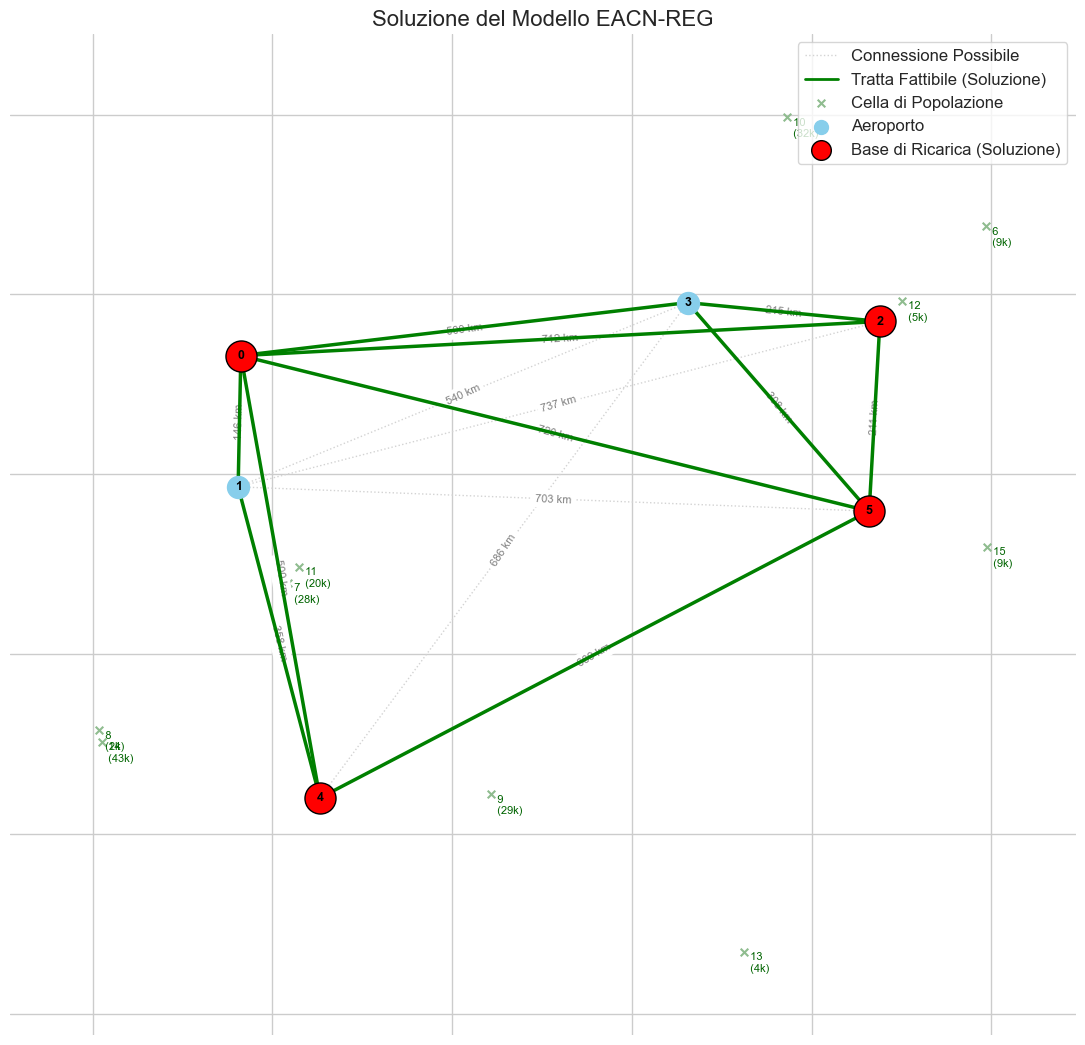

In [379]:
try:
    # --- 1. Estrazione dei Risultati dal Modello Gurobi ---
    if m.Status in (GRB.OPTIMAL, GRB.TIME_LIMIT) and m.SolCount > 0:
        active_bases = [i for i in airports if y[i].X > 0.5]
        feasible_edges = [edge for edge in z if z[edge].X > 0.5]

        print(f"\nVisualizzazione della soluzione: {len(active_bases)} basi, {len(feasible_edges)} tratte fattibili.")

        # --- 2. Preparazione del Grafico ---
        plt.figure(figsize=(15, 13))
        airports_plot_df = data_df[data_df['type'] == 'airport']
        population_plot_df = data_df[data_df['type'] == 'population']
        pos = {row['id']: (row['x'], row['y']) for _, row in airports_plot_df.iterrows()}

        # Etichette distanze sugli archi di G
        edge_labels = {(u, v): f"{dist[u, v]:.0f} km" for u, v in G.edges()}

        # --- 3. Disegno ---
        nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1.0, style='dotted')
        plt.scatter(population_plot_df['x'], population_plot_df['y'], s=30, c='darkseagreen', marker='x')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray', font_size=8)
        nx.draw_networkx_nodes(G, pos, nodelist=airports, node_color='skyblue', node_size=250)
        nx.draw_networkx_edges(G, pos, edgelist=feasible_edges, edge_color='green', width=2.5)
        nx.draw_networkx_nodes(G, pos, nodelist=active_bases, node_color='red', node_size=500, edgecolors='black')
        nx.draw_networkx_labels(G, pos, font_size=9, font_color='black', font_weight='bold')

        for _, row in population_plot_df.iterrows():
            label_text = f"  {row['id']}\n  ({row['population']/1000:.0f}k)"
            plt.text(row['x'], row['y'], label_text, fontsize=8, color='darkgreen', va='top')

        # --- 4. Abbellimento ---
        plt.title('Soluzione del Modello EACN-REG', fontsize=16)
        plt.box(False)
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        ax.margins(0.1) 
        plt.legend(handles=[
            plt.Line2D([0], [0], color='lightgray', lw=1, linestyle='dotted', label='Connessione Possibile'),
            plt.Line2D([0], [0], color='green', lw=2, label='Tratta Fattibile (Soluzione)'),
            plt.scatter([], [], s=30, c='darkseagreen', marker='x', label='Cella di Popolazione'),
            plt.scatter([], [], s=100, c='skyblue', label='Aeroporto'),
            plt.scatter([], [], s=200, c='red', edgecolors='black', label='Base di Ricarica (Soluzione)')
        ], loc='upper right', fontsize=12)
        plt.show()

    else:
        print(f"Modello terminato con stato {m.Status}. Nessuna soluzione da visualizzare.")

except Exception as e:
    print(f"Errore durante la creazione del grafico: {e}")
